In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Creating the datasets

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



def create_training_tensors_cifar(directory):
    training_data = []
    training_labels = []
    for i in range (1,6):
        filename = directory + 'data_batch_{}'.format(i)
        dictionary = unpickle(filename)
        
        data = dictionary[b'data']
        data = np.reshape(data, newshape=(10000, 3, 32, 32))
        data = np.swapaxes(data, 1, 3)
        data = np.swapaxes(data, 1, 2)
        training_data.append(data)
        
        labels = dictionary[b'labels']
        training_labels.append(labels)
        
    training_data = np.array(training_data)
    training_data = np.reshape(training_data, newshape=(50000,32,32,3))
    training_labels = np.array(training_labels)
    training_labels = np.reshape(training_labels, newshape=(50000,))
    
    return training_data, training_labels
        
    
def create_validation_tensors_cifar(directory):

    filename = directory + 'test_batch'
    dictionary = unpickle(filename)

    data = dictionary[b'data']
    data = np.reshape(data, newshape=(10000, 3, 32, 32))
    data = np.swapaxes(data, 1, 3)
    data = np.swapaxes(data, 1, 2)
    
    labels = dictionary[b'labels']
    labels = np.array(labels)
    
    return data, labels
               

        
training_data, training_labels = create_training_tensors_cifar('/Users/Ronja/Downloads/ANNs_h3/cifar-10-python/cifar-10-batches-py/')
validation_data, validation_labels = create_validation_tensors_cifar('/Users/Ronja/Downloads/ANNs_h3/cifar-10-python/cifar-10-batches-py/')


label_to_word = {
    0: "Airplane",
    1: "Autombile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}


## Investigate the data

Frog
Truck
Truck
Deer
Autombile
Autombile
Bird
Horse
Ship
Cat


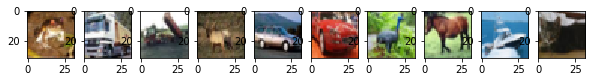

In [3]:
# displaying the first 10 training examples and labels
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10): 
    ax[i].imshow(training_data[i])
    print(label_to_word[training_labels[i]])

## Making the datasets

In [4]:
# create the tensorflow dataset
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# define the batch size
training_batchsize = 200
validation_batchsize = 10000

# split the dataset into batches
training_dataset = training_dataset.batch(training_batchsize)
validation_dataset = validation_dataset.batch(validation_batchsize)

# shuffel the data (in each epoch)
training_dataset = training_dataset.shuffle(buffer_size=4, reshuffle_each_iteration=True)

## Creating an iterator

In [5]:
# create an iterator
iterator = tf.data.Iterator.from_structure(training_dataset.output_types, training_dataset.output_shapes)

# name operation that gives next batch
next_batch = iterator.get_next()

# initializer operations for training and validation dataset
training_initialize_iterator = iterator.make_initializer(training_dataset)
validation_initialize_iterator = iterator.make_initializer(validation_dataset)

# Building the model

## Formarting the data


In [6]:
#get the batch 
input_data = next_batch[0]
input_data = tf.cast(input_data, tf.float32)
labels = next_batch[1]

#make a one hot vector out of labels
labels = tf.cast(labels, tf.int32)
one_hot_labels = tf.one_hot(labels, 10)

## applying convolutional layers

In [7]:
#intializing the convolutional layers with:
    #kernels = tf.Variable(tf.truncated_normal([kernel size, kernel size, channels, number of kernels], stddev = 0.1))
    #biases = tf.Variable(tf.zeros([number of kernels]))
    #convolution = convolution = tf.nn.conv2d(input, kernels, strides = [1, stride, stride, 1], padding = "padding mode")
    #feature_maps = activation_function(convolution + biases)
    #pooling = tf.nn.max_pool(feature_maps, ksize = [1, kernelsize, kernelsize, 1], strides = [1, stride, stride, 1], padding = "SAME")

#initializing for convolutional layer 1 (kernelsize: 5, stride: 1, number k.: 16, padding: same, activation f.: tanh)
# + pooling layer 1 with: kernel size: 2, stride: 2, padding: same
with tf.variable_scope("conv_layer1"):
    kernels = tf.Variable(tf.truncated_normal([5, 5, 3, 16], stddev = 0.1))
    biases = tf.Variable(tf.zeros([16]))
    convolution = convolution = tf.nn.conv2d(input_data, kernels, strides = [1, 1, 1, 1], padding = "SAME")
    feature_maps = tf.tanh(convolution + biases)
    pooling = tf.nn.max_pool(feature_maps, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
    
#initializing con. layer 2 (kernel size: 3, stride: 1, number of kernels: 32, padding: same, activation function: tanh)  
# + pooling layer 2 with: kernel size: 2, stride: 2, padding: same
with tf.variable_scope("conv_layer2"):
    kernels = tf.Variable(tf.truncated_normal([3, 3, 16, 32], stddev = 0.1))
    biases = tf.Variable(tf.zeros([32]))
    convolution = convolution = tf.nn.conv2d(pooling, kernels, strides = [1, 1, 1, 1], padding = "SAME")
    feature_maps = tf.tanh(convolution + biases)
    pooling2 = tf.nn.max_pool(feature_maps, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
    print(pooling2.shape)

(?, 8, 8, 32)


## applying fully connected layers

In [8]:
with tf.variable_scope("fully_layer1"):
    #flattening the output of the second pooling layer 
    flat_pooling2 = tf.reshape(pooling2, shape=[-1,2048])
    #standard deviation is 1/sqrt(neurons in last layer)
    strd_dev = 1/tf.sqrt(2048.0)
    weights = tf.truncated_normal([2048, 512], stddev=strd_dev)
    weights = tf.Variable(weights, dtype=tf.float32)
    biases = tf.zeros(512)
    biases = tf.Variable(biases, dtype=tf.float32)
    drive = flat_pooling2 @ weights + biases
    activation = tf.tanh(drive)
    
with tf.variable_scope("fully_layer2"):
    #standard deviation is 1/sqrt(neurons in last layer)
    strd_dev = 1/tf.sqrt(512.0)
    weights = tf.truncated_normal([512, 10], stddev=strd_dev)
    weights = tf.Variable(weights, dtype=tf.float32)
    biases = tf.zeros(10)
    biases = tf.Variable(biases, dtype=tf.float32)
    logits = activation @ weights + biases
    output = tf.nn.softmax(logits)

## metrics

In [9]:
#getting loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#getting accuracy
argmax = tf.argmax(output, axis=1)
argmax = tf.cast(argmax, tf.int32)
match_bools = tf.equal(labels, argmax)
accuracy = tf.reduce_mean(tf.cast(match_bools, dtype=tf.float32))

## optimizer

In [10]:
#defining the learning rate
learning_rate = 1e-4

#defining the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

#define training step
training_step = optimizer.minimize(loss)

## summaries

In [11]:
# adding summaries for loss and accuracy
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

#merging summaries
merged_summaries = tf.summary.merge_all()
#making file writers for training and validation metrics
train_writer = tf.summary.FileWriter('/Users/Ronja/Downloads/ANNs_h3/summaries/train/')
validation_writer = tf.summary.FileWriter('/Users/Ronja/Downloads/ANNs_h3/summaries/validation/', flush_secs =2)

# Training

In [12]:
#defining the epochs
epochs = 5
#starting Tensorflow session
with tf.Session() as sess:
    #inizializing variables
    sess.run(tf.global_variables_initializer())
    #making global step counter
    global_step = 0
    #defining the epoch loop (runs through training and validation epoch number of times)
    for _ in range(epochs):
        #initializing iterator with training data for this epoch
        sess.run(training_initialize_iterator)
        #going through all batches once
        while True:
            try:
                #running training step and reading out summary
                _, summary  = sess.run((training_step, merged_summaries))
                #saving the summary
                train_writer.add_summary(summary, global_step)
                #incrementing global step
                global_step = global_step + 1
            except tf.errors.OutOfRangeError:
                break
        
        #Validation part
        #initializing the iterator
        sess.run(validation_initialize_iterator)
        #reading out summary
        summary = sess.run((merged_summaries))
        #saving summary
        validation_writer.add_summary(summary, global_step)

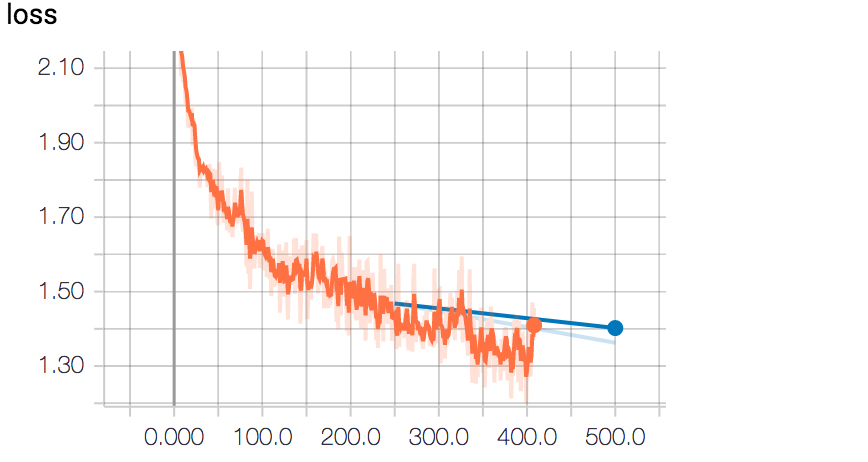


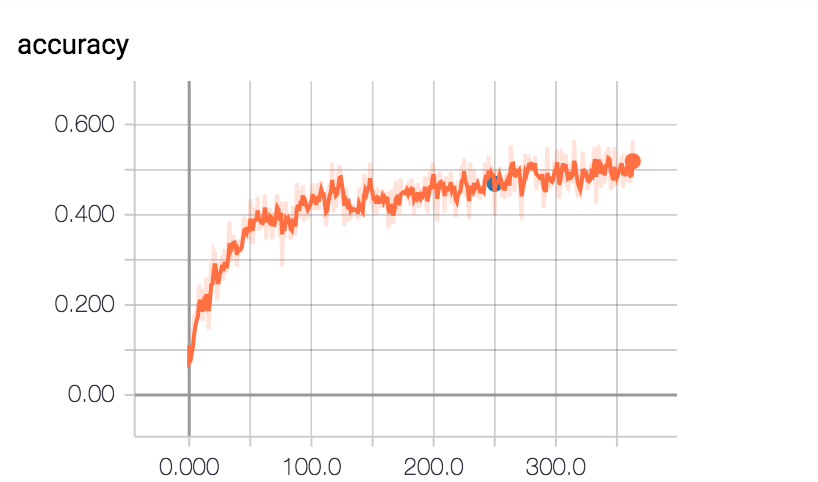